In [1]:
!pip install --upgrade pip

ERROR: To modify pip, please run the following command:
C:\Users\igerl\anaconda3\python.exe -m pip install --upgrade pip



  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/ef/7d/500c9ad20238fcfcb4cb9243eede163594d7020ce87bd9610c9e02771876/pip-24.3.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 330.3 kB/s eta 0:00:06
   - -------------------------------------- 0.1/1.8 MB 469.7 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/1.8 MB 919.0 kB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.8 MB 1.4 MB/s eta 0:00:02
   -------- ------------------------------- 0.4/1.8 MB 1.4 MB/s eta 0:00:02
   ------------- -------------------------- 0.6/1.8 MB 2.2 MB/s eta 0:00:01
   -------------------- ------------------- 0.9/1.8 MB 2.6 MB/s eta 0:00:01
   ---------------------------- ----------- 1.3/1.8 MB 3.3 MB/

In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set style options for plots
plt.style.use('default')  # Using default style instead of seaborn
sns.set_theme(style="whitegrid", palette="deep")  # Setting seaborn theme

In [6]:
def load_retail_data():
    retail_df = pd.read_excel('Online_Retail.xlsx')
    retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])
    retail_df['Total_Amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
    retail_df = retail_df.dropna(subset=['CustomerID'])
    retail_df = retail_df[retail_df['Quantity'] > 0]
    retail_df = retail_df[retail_df['UnitPrice'] > 0]
    return retail_df

def load_survey_data():
    survey_df = pd.read_csv('survey_responses.csv')
    le_dict = {}
    categorical_cols = ['Gender', 'Country', 'Store Types Used', 'Shopping Frequency', 'Card Storage Method', 'Feature Preferences']
    
    for col in categorical_cols:
        le_dict[col] = LabelEncoder()
        survey_df[col] = le_dict[col].fit_transform(survey_df[col])
    
    age_mapping = {'18-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55+': 5}
    survey_df['Age'] = survey_df['Age'].map(age_mapping)
    survey_df['Adoption_Likelihood_Score'] = pd.to_numeric(survey_df['Adoption Likelihood'])
    return survey_df, le_dict

retail_df = load_retail_data()
survey_df, label_encoders = load_survey_data()

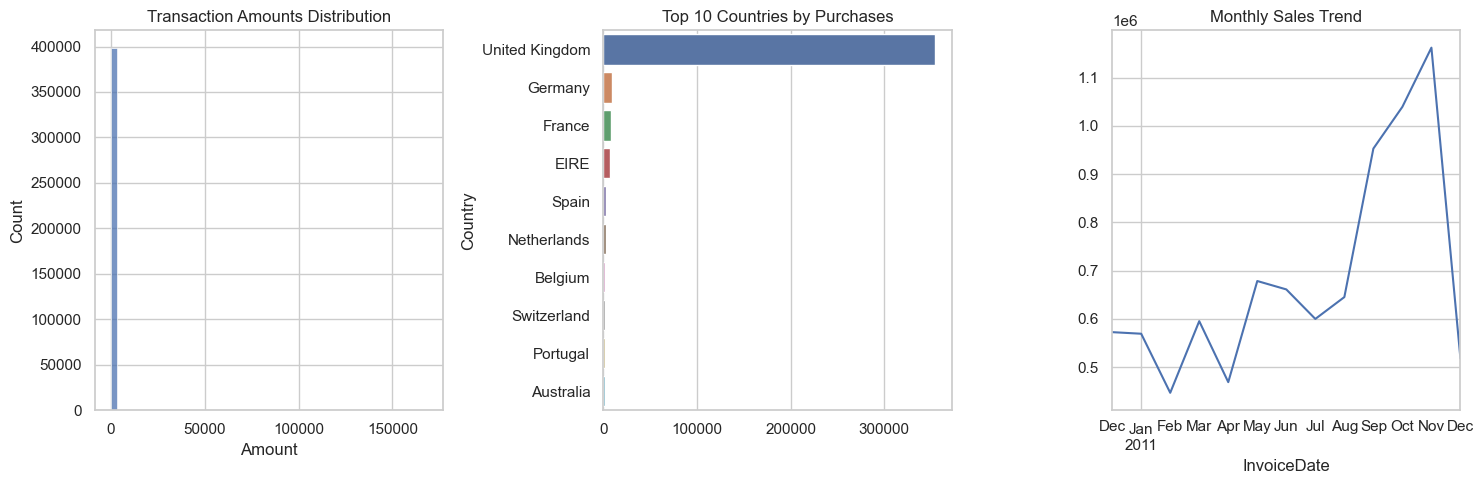

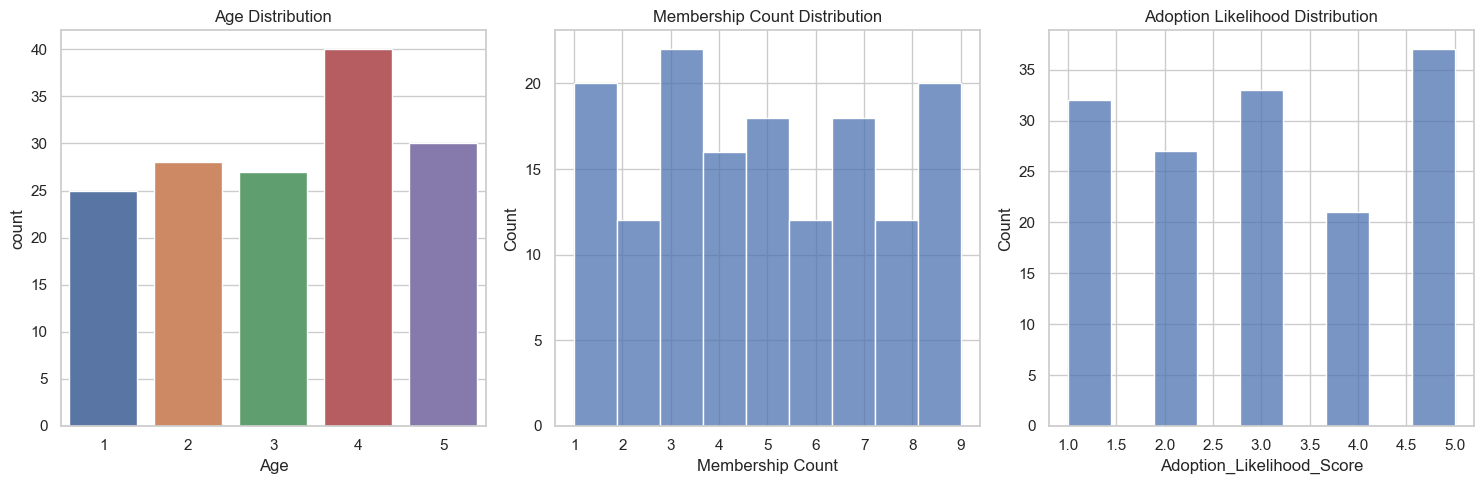

In [7]:
def perform_eda():
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(retail_df['Total_Amount'], bins=50)
    plt.title('Transaction Amounts Distribution')
    plt.xlabel('Amount')
    
    plt.subplot(1, 3, 2)
    country_counts = retail_df['Country'].value_counts().head(10)
    sns.barplot(x=country_counts.values, y=country_counts.index)
    plt.title('Top 10 Countries by Purchases')
    
    plt.subplot(1, 3, 3)
    retail_df.set_index('InvoiceDate')['Total_Amount'].resample('M').sum().plot()
    plt.title('Monthly Sales Trend')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.countplot(data=survey_df, x='Age')
    plt.title('Age Distribution')
    
    plt.subplot(1, 3, 2)
    sns.histplot(data=survey_df, x='Membership Count')
    plt.title('Membership Count Distribution')
    
    plt.subplot(1, 3, 3)
    sns.histplot(data=survey_df, x='Adoption_Likelihood_Score')
    plt.title('Adoption Likelihood Distribution')
    
    plt.tight_layout()
    plt.show()

perform_eda()

In [8]:
def create_customer_features(retail_df):
    customer_stats = retail_df.groupby('CustomerID').agg({
        'InvoiceNo': 'count',
        'Total_Amount': ['sum', 'mean', 'std'],
        'InvoiceDate': ['min', 'max']
    }).reset_index()
    
    customer_stats.columns = ['CustomerID', 'purchase_count', 'total_spend', 
                            'avg_transaction_value', 'std_transaction_value',
                            'first_purchase', 'last_purchase']
    
    customer_stats['customer_lifetime_days'] = (
        customer_stats['last_purchase'] - customer_stats['first_purchase']
    ).dt.days
    
    customer_stats['purchase_frequency'] = (
        customer_stats['customer_lifetime_days'] / customer_stats['purchase_count']
    )
    
    last_date = retail_df['InvoiceDate'].max()
    customer_stats['recency_days'] = (
        last_date - customer_stats['last_purchase']
    ).dt.days
    
    return customer_stats

customer_features = create_customer_features(retail_df)

In [9]:
def prepare_final_features(customer_features, survey_df):
    final_features = pd.DataFrame()
    
    final_features['customer_value'] = customer_features['total_spend']
    final_features['purchase_frequency'] = customer_features['purchase_frequency']
    final_features['customer_lifetime'] = customer_features['customer_lifetime_days']
    final_features['recency'] = customer_features['recency_days']
    
    final_features['age_group'] = survey_df['Age']
    final_features['gender'] = survey_df['Gender']
    final_features['membership_count'] = survey_df['Membership Count']
    final_features['shopping_frequency'] = survey_df['Shopping Frequency']
    final_features['unified_preference'] = survey_df['Unified System Preference']
    final_features['adoption_likelihood'] = survey_df['Adoption_Likelihood_Score']
    
    scaler = StandardScaler()
    numerical_cols = ['customer_value', 'purchase_frequency', 'customer_lifetime',
                     'recency', 'membership_count', 'shopping_frequency']
    final_features[numerical_cols] = scaler.fit_transform(final_features[numerical_cols])
    
    return final_features

final_features = prepare_final_features(customer_features, survey_df)

In [10]:
def create_model(input_shape):
    inputs = Input(shape=(input_shape,))
    
    value_branch = Dense(32, activation='relu')(inputs)
    value_branch = BatchNormalization()(value_branch)
    value_branch = Dropout(0.3)(value_branch)
    
    behavior_branch = Dense(32, activation='relu')(inputs)
    behavior_branch = BatchNormalization()(behavior_branch)
    behavior_branch = Dropout(0.3)(behavior_branch)
    
    merged = Concatenate()([value_branch, behavior_branch])
    
    x = Dense(64, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [11]:
X = final_features.drop('adoption_likelihood', axis=1)
y = (final_features['adoption_likelihood'] > final_features['adoption_likelihood'].median()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = create_model(X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train, y_train,
                   validation_split=0.2,
                   epochs=100,
                   batch_size=32,
                   callbacks=[early_stopping, reduce_lr],
                   verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/100
87/87 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9914 - lr: 0.0010
Epoch 2/100
87/87 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9914 - lr: 0.0010
Epoch 3/100
87/87 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9914 - lr: 0.0010
Epoch 4/100
87/87 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9914 - lr: 0.0010
Epoch 5/100
87/87 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9914 - lr: 0.0010
Epoch 6/100
87/87 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9914 - lr: 2.0000e-04
Epoch 7/100
87/87 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.9852 - val_loss: 

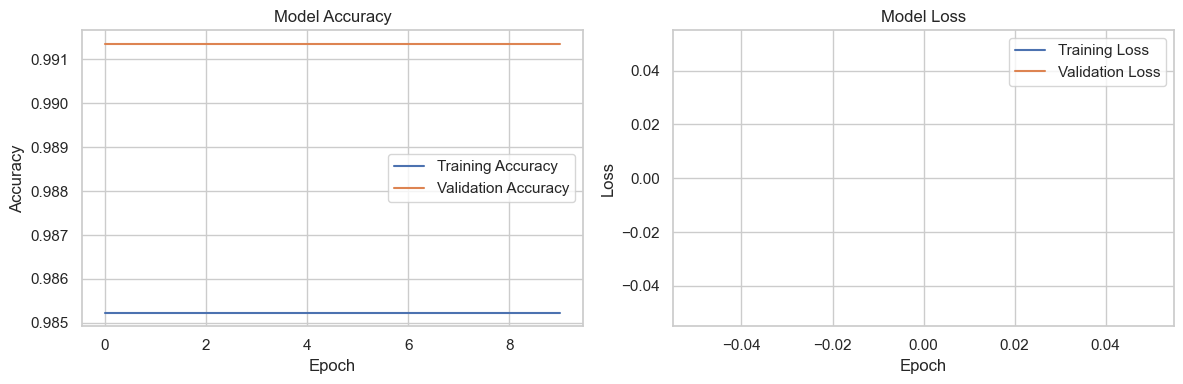

28/28 [==============================] - 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       857
           1       0.00      0.00      0.00        11

    accuracy                           0.99       868
   macro avg       0.49      0.50      0.50       868
weighted avg       0.97      0.99      0.98       868



C:\Users\igerl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\igerl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\igerl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print('\nClassification Report:')
print(classification_report(y_test, y_pred_classes))